# Assignment 5 - Parameter Identification

## Goal of the Experiment
The goal of this experiment is to determine the stiffness (\(k\)) and damping (\(b\)) parameters of cardstock material. By conducting controlled oscillation tests on the 5 layer cardstock, capturing real-world data, and comparing it to simulated data in MuJoCo, we aim to identify parameters that best approximate the cardstock’s behavior.


## Experiment
The experiment was a dynamic cantilever beam experiment.
One side was fixed to the table through a weight, while the other had a mass on the end and was dropped to observe the oscillations. A strip of paper was placed on the end of the beam to place a marker on to allow for better motion tracking. A camera was placed on a steady tri-pod approximatley 3 feet away recording at 30fps 1080p to collect data.




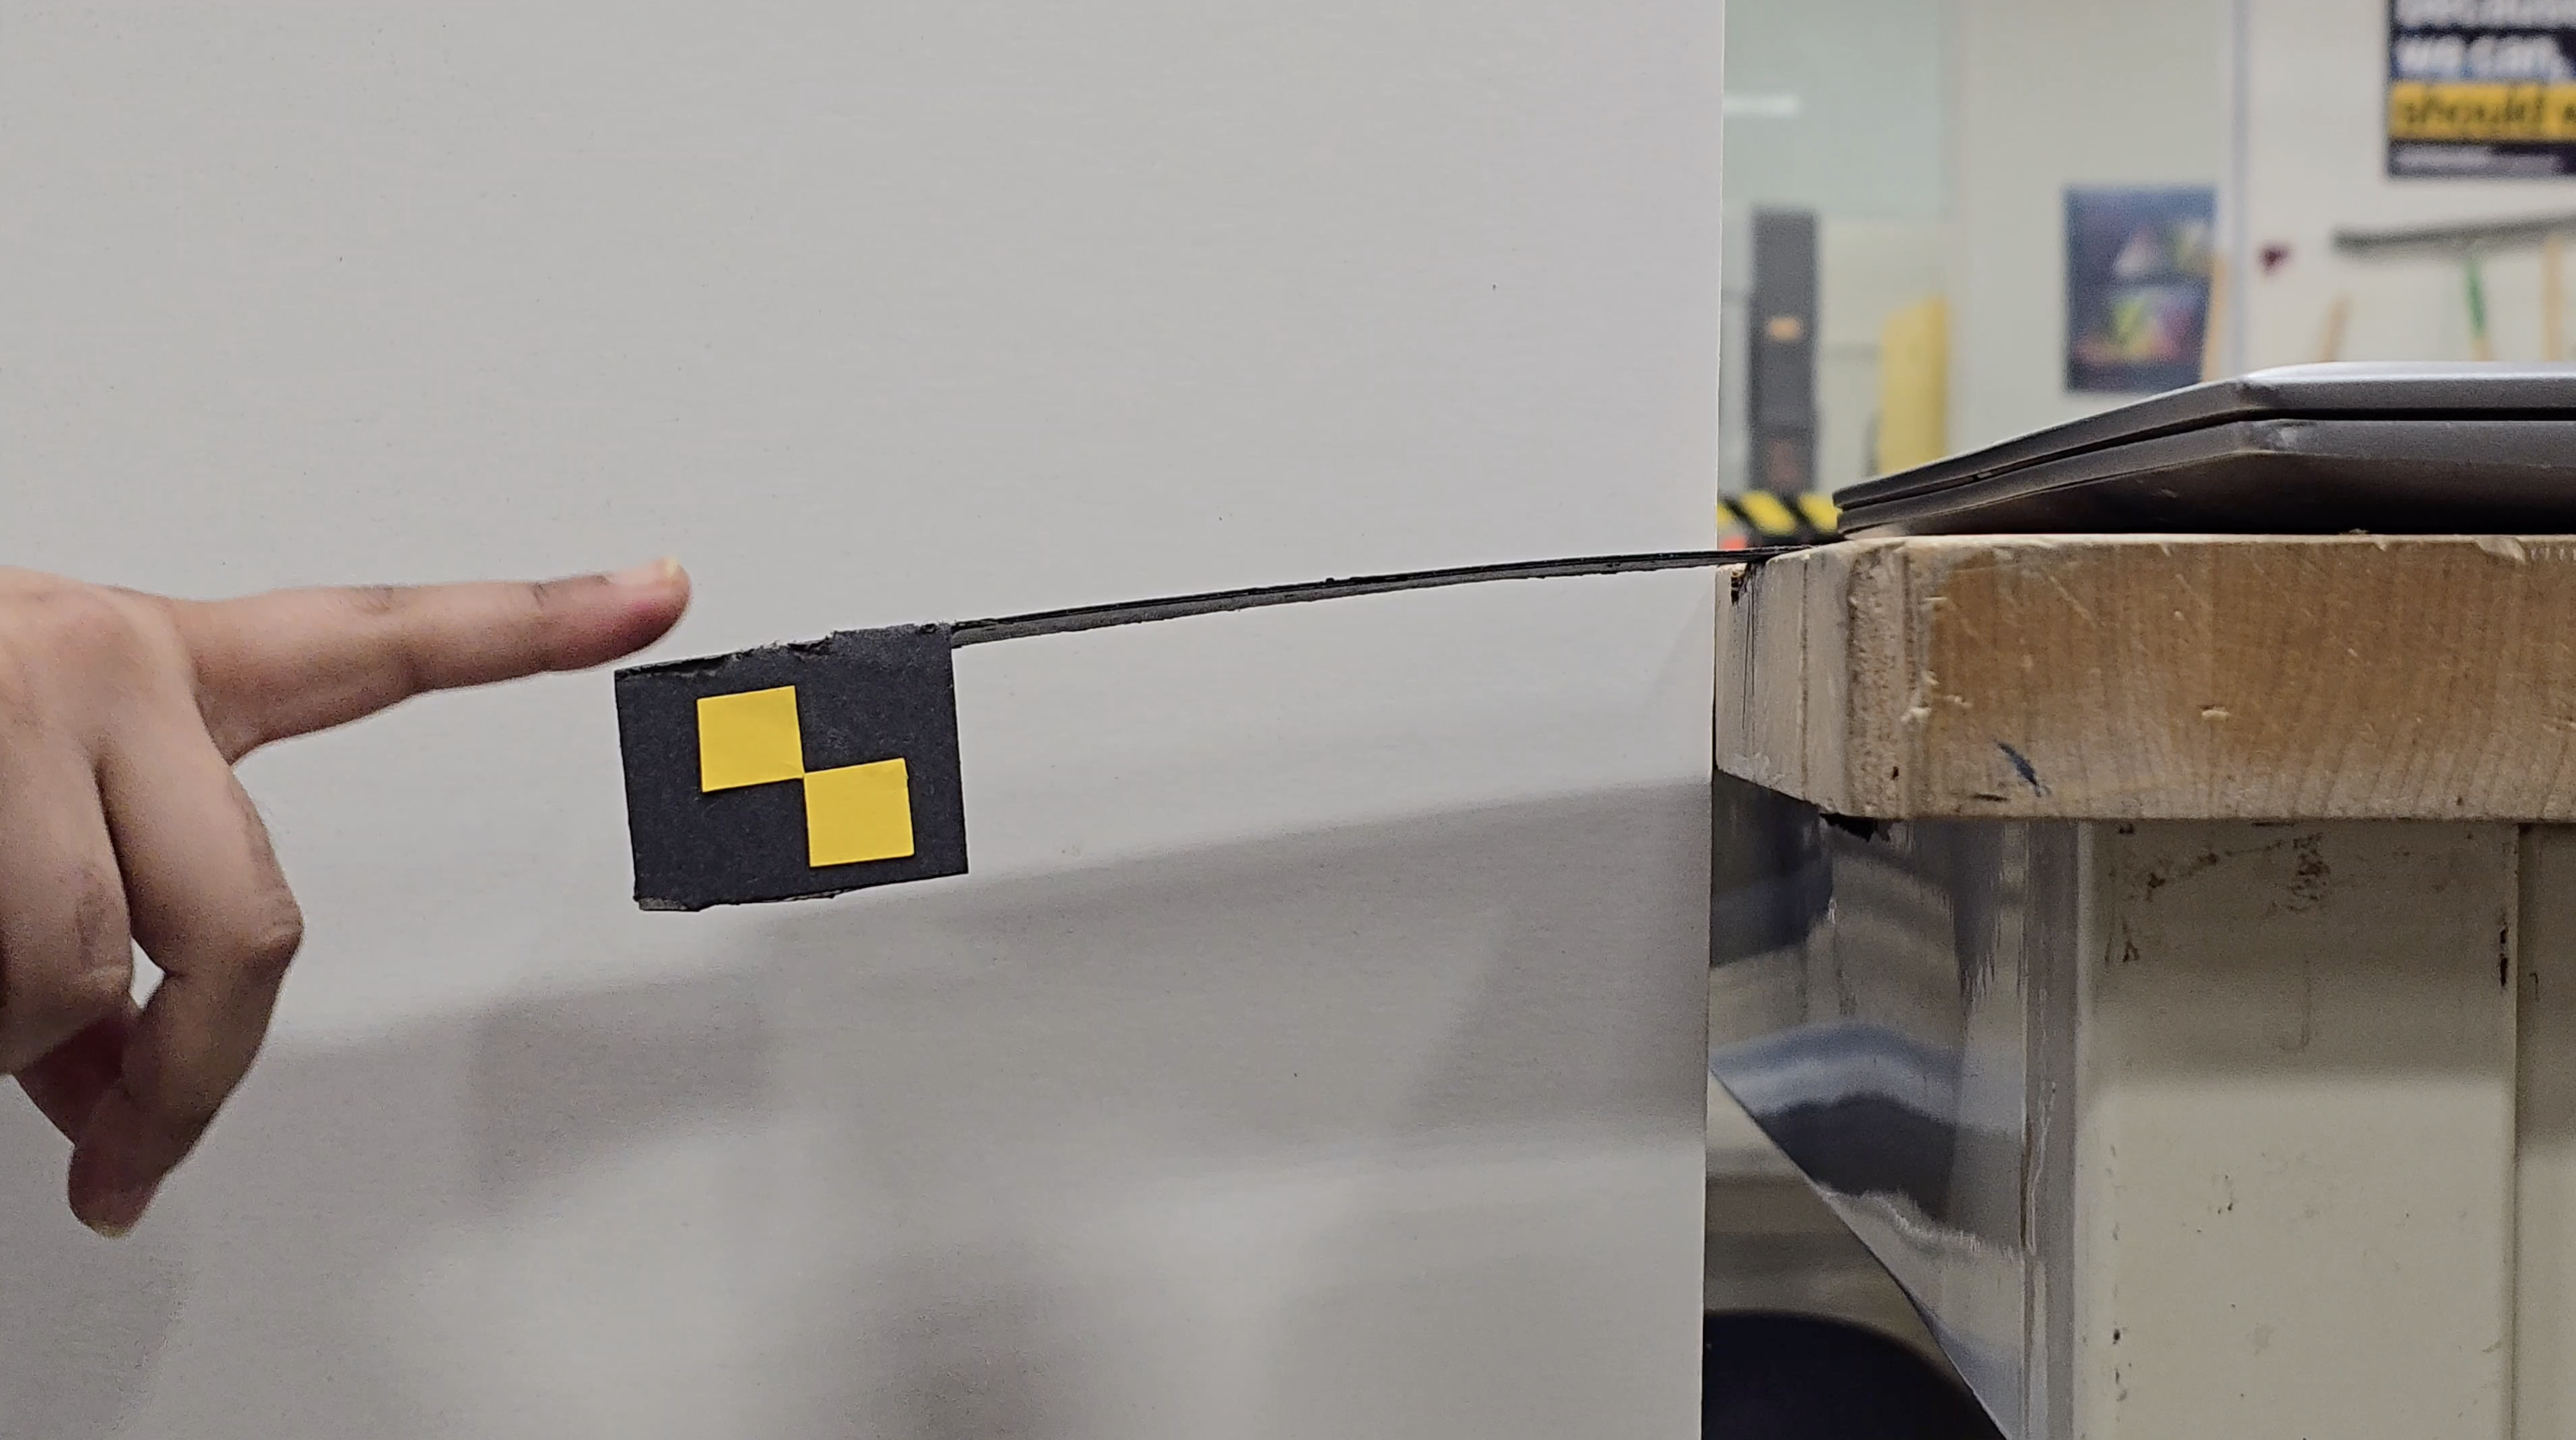

### Data Capture
- **Software Used:** The oscillation data was captured using the software *Tracker*, which tracked the x and y positions of the weight at each timestep.
- **Data Collected:** For each timestep, the software recorded the x and y values, representing the motion in three dimensions.


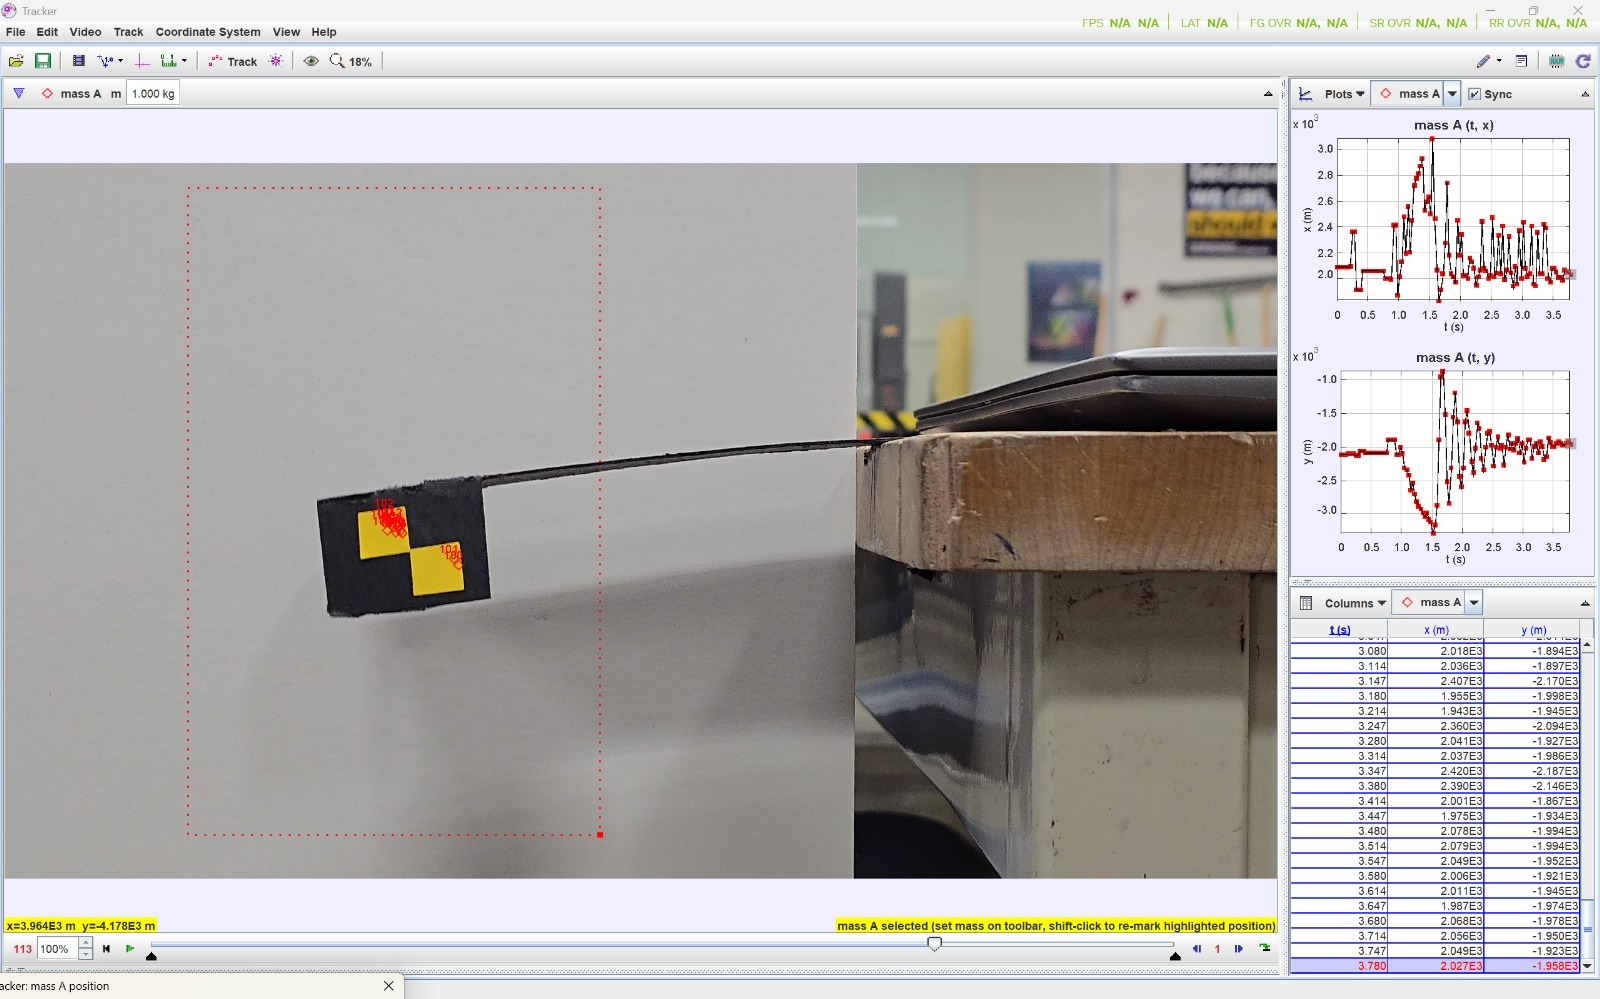

In [7]:
!pip install mujoco mediapy

In [8]:
!pip install vector

In [9]:
!pip install "numpy<2.0"

In [10]:
import os
import mujoco
import numpy
import time
import mediapy as media
import matplotlib.pyplot as plt
import scipy.optimize as so
import imageio.v3 as iio
import scipy.interpolate as si
import pandas as pd
from scipy.signal import find_peaks

In [11]:
df = pd.read_csv('tt.csv', sep=',')
df

t         x         y
0    0.000000  2088.727 -2112.000
1    0.033425  2090.148 -2111.947
2    0.066849  2090.414 -2112.263
3    0.100274  2090.894 -2110.041
4    0.133698  2090.747 -2110.040
..        ...       ...       ...
109  3.643284  1986.722 -1974.211
110  3.676709  2067.857 -1977.658
111  3.710133  2055.683 -1950.175
112  3.743558  2048.949 -1923.378
113  3.776983  2027.049 -1957.860

[114 rows x 3 columns]

- Reads the experimental tracking data from tt.csv into a DataFrame df.
- Displaying df (in a notebook) shows the table of data: typically columns like t, x, y.

In [13]:
import numpy as np
x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()

# 2. Fix: Calculate Theta using NumPy (Vector replacement)
# np.arctan2(y, x) calculates the angle relative to the positive x-axis (1,0)
# This replaces the manual loop and Vector class.
theta = np.arctan2(y, x)

# Note: Your original code applied a negative sign (-link...). 
# If the rotation direction looks wrong, uncomment the line below:
# theta = -theta

# 3. Interpolation
xy = np.array([x, y]).T
f = si.interp1d(t, xy.T, fill_value='extrapolate', kind='quadratic')
h = si.interp1d(t, theta, fill_value='extrapolate', kind='quadratic')

new_t = np.arange(0, t[-1], 0.01)
len(new_t)

378

- Extracts x, y, and t arrays from the DataFrame.

- Computes theta(t) = arctan2(y, x), the angle of the marker relative to the positive x‑axis.

- arctan2 correctly handles quadrants and division by zero.

- A commented alternative theta = -theta is there if the sign convention is reversed.

- Builds interpolation functions:f(t) returns [x(t), y(t)] using quadratic interpolation.h(t) returns the interpolated angle theta(t).

- new_t is a new uniformly spaced time array with step 0.01 s, from 0 to the last time stamp.

This creates a smooth, uniformly sampled version of the measured motion.

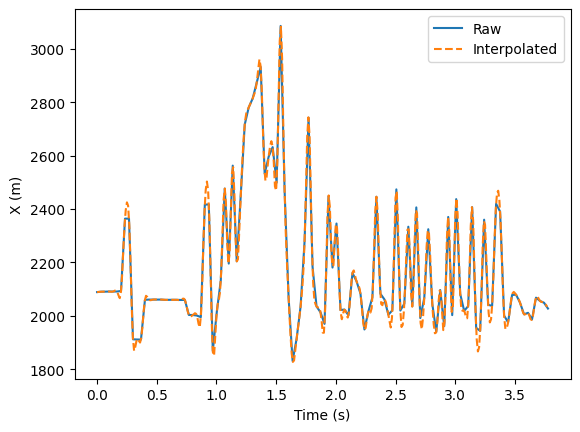

In [15]:
plt.figure()
plt.plot(t, x, label='Raw')
plt.plot(new_t, f(new_t)[0], '--', label='Interpolated')
plt.xlabel('Time (s)')
plt.ylabel('X (m)')
plt.legend()

Plots original x(t) data and the interpolated x(t) on the same figure to visually verify the interpolation quality on the x‑coordinate.

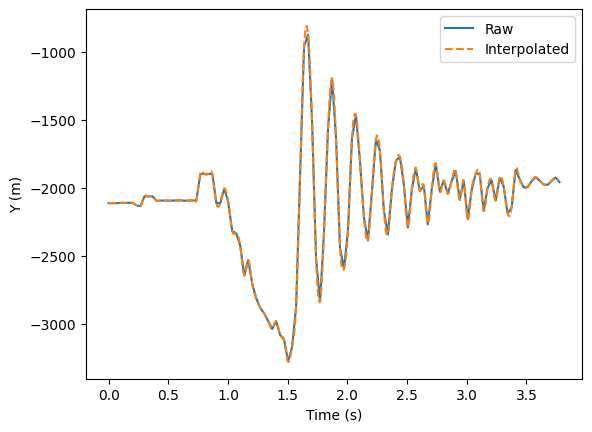

In [17]:
plt.figure()
plt.plot(t, y, label='Raw')
plt.plot(new_t, f(new_t)[1], '--', label='Interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Y (m)')
plt.legend()

Plots original y(t) data and the interpolated y(t) on the same figure to visually verify the interpolation quality on the y‑coordinate.

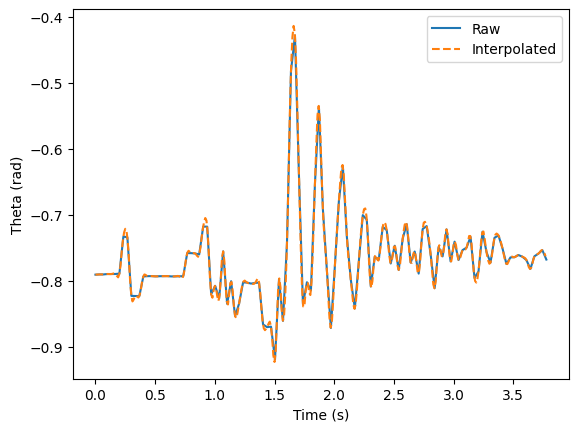

In [19]:
plt.figure()
plt.plot(t, theta, label='Raw')
plt.plot(new_t, h(new_t), '--', label='Interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.legend()

Plots the angle θ(t) from raw data and its interpolated version. Again, this is a sanity check that interpolation is reasonable.

Text(0.5, 1.0, 'Trajectory')

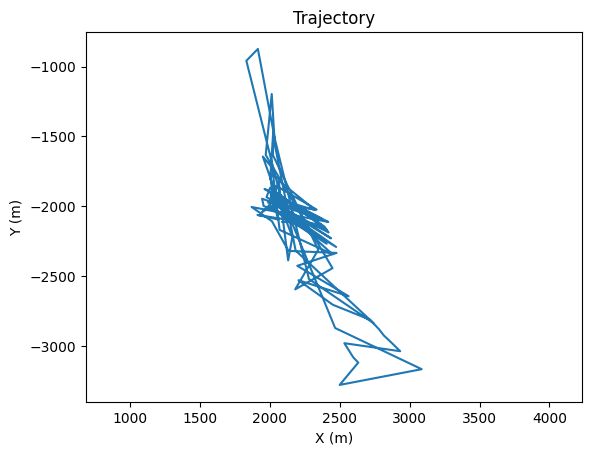

In [21]:
plt.figure()
plt.plot(x, y)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.title('Trajectory')

- Plots the tip path in the x–y plane, giving a 2D trajectory of the motion.
- plt.axis('equal') ensures equal scaling in x and y so the path isn’t distorted.

In [23]:
f_result = numpy.array([[f(t_val)[0], 0, f(t_val)[1]] for t_val in new_t])
f_result.shape

(378, 3)

- Builds a 3D position array f_result of shape (N, 3):

  - x coordinate = interpolated x

  - y coordinate = 0 (assumes all motion lies in the x–z or x–y plane)

  - z coordinate = interpolated y

- This makes the experimental data compatible with MuJoCo’s expected 3D position format.

- f_result.shape just shows the dimensions.

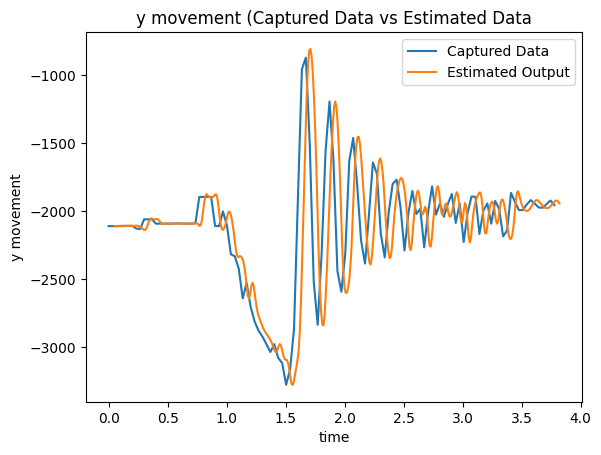

In [25]:
# checking if the function f models the captured data accurately

plt.figure()
plt.plot(t,y, label='Captured Data')
plt.plot(new_t+0.05,f(new_t)[1], label='Estimated Output') # plotting with offset for visual purposes
plt.xlabel('time')
plt.ylabel('y movement')
plt.title('y movement (Captured Data vs Estimated Data')
plt.legend()

Text(0, 0.5, 'y detrended')

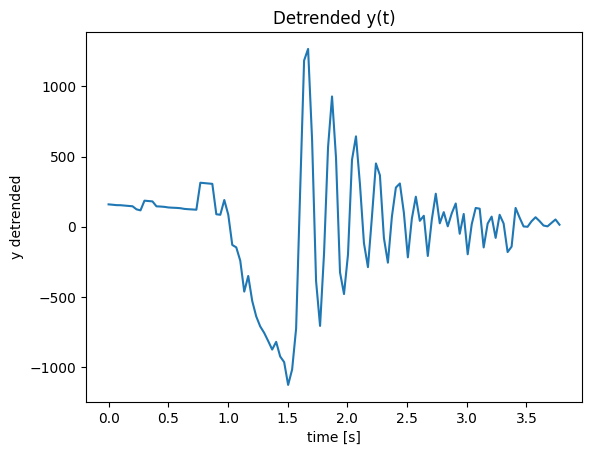

In [26]:
# 2. Detrend y(t) so it oscillates around zero

coeffs = numpy.polyfit(t, y, 1)          # linear trend
trend = numpy.polyval(coeffs, t)
y_detrended = y - trend

plt.figure()
plt.plot(t, y_detrended)
plt.title('Detrended y(t)')
plt.xlabel('time [s]')
plt.ylabel('y detrended')

Text(0, 0.5, 'y detrended')

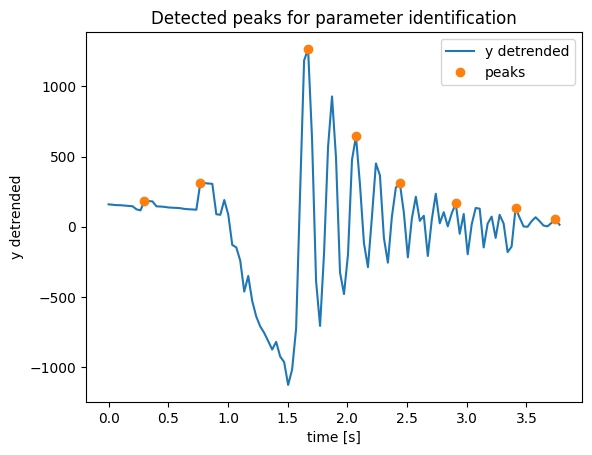

In [27]:
#3. Find peaks of the oscillation
#    distance=10 enforces a minimum separation in samples
#    (10 * 0.02 s = 0.2 s here), to avoid tiny spurious peaks.

peaks, properties = find_peaks(y_detrended, height=0, distance=10)
peak_times = t[peaks]
peak_amps = y_detrended[peaks]

plt.figure()
plt.plot(t, y_detrended, label='y detrended')
plt.plot(peak_times, peak_amps, 'o', label='peaks')
plt.legend()
plt.title('Detected peaks for parameter identification')
plt.xlabel('time [s]')
plt.ylabel('y detrended')

- Uses find_peaks to detect local maxima of the detrended oscillation.

- distance=10 enforces a minimum spacing between peaks → filters out noise.

- Extracts peak times and amplitudes, then plots them over the detrended signal.

- These peaks are used to compute oscillation period & damping.

In [29]:
# 4. Mean period T from peak-to-peak times

periods = numpy.diff(peak_times)
T = periods.mean()     # average period [s]


- Computes time differences between consecutive peaks → individual periods.

- Takes their average to get the mean oscillation period 𝑇


In [31]:
# 5. Logarithmic decrement δ and damping ratio ζ
max_idx = numpy.argmax(peak_amps)
valid_peaks = peak_amps[max_idx:] # Start from the maximum peak

# Filter noise (threshold)
amp_threshold = 0  # Or: amp_threshold = 0.1 * peak_amps.max()
valid_peaks = valid_peaks[valid_peaks > amp_threshold]


# Calculate Log Dec
delta_i = numpy.log(valid_peaks[:-1] / valid_peaks[1:])
delta = delta_i.mean()
zeta = delta / numpy.sqrt(4 * numpy.pi**2 + delta**2)

* Finds the **largest peak** and only uses peaks after that (so amplitude monotonically decays).
* Optionally filters out tiny peaks below some threshold (to avoid noise).
* Computes **logarithmic decrement**:

    $$
    \delta_i = \ln \left( \frac{A_i}{A_{i+1}} \right)
    $$

    and averages to get $\delta$.
* Converts $\delta$ to **damping ratio** $\zeta$ using the standard 2nd-order system formula:

    $$
    \zeta = \frac{\delta}{\sqrt{4\pi^2 + \delta^2}}
    $$

In [33]:

m_total = 0.015
start_frames = 120 #(as per tracker)
start_sec = start_frames / 30


In [34]:
#7. Frequencies, k_total and b_total

omega_d = 2 * numpy.pi / T
omega_n = omega_d / numpy.sqrt(1 - zeta**2)

k_total = m_total * omega_n**2          # [N/m]
b_total = 2 * zeta * m_total * omega_n  # [N·s/m]

* Computes **damped** angular frequency
  $\omega_d = 2\pi/T$.

* Uses damping ratio $\zeta$ to get the **natural (undamped)** frequency
  $\omega_n = \omega_d / \sqrt{1 - \zeta^2}$.

* Then for a 1-DOF mass–spring–damper model:

  $$
  k = m\omega_n^2, \quad b = 2\zeta m \omega_n
  $$

  giving **total stiffness** `k_total` and **total damping** `b_total` of the equivalent oscillator describing the tip motion.

In [36]:
print("mass_paper (kg)        =", m_total)
print("mean period T (s)      =", T)
print("logarithmic decrement δ =", delta)
print("damping ratio ζ        =", zeta)
print("omega_d (rad/s)        =", omega_d)
print("omega_n (rad/s)        =", omega_n)
print("k_total (N/m)          =", k_total)
print("b_total (N·s/m)        =", b_total)

mass_paper (kg)        = 0.015
mean period T (s)      = 0.49181948571428574
logarithmic decrement δ = 0.6400376870837731
damping ratio ζ        = 0.10134073693440035
omega_d (rad/s)        = 12.775389120775294
omega_n (rad/s)        = 12.841500047082661
k_total (N/m)          = 2.47356185188836
b_total (N·s/m)        = 0.03904101234343481


In [37]:
import mujoco
import numpy
import mediapy as media

In [38]:
main_template = """
<mujoco>
    <option><flag contact="disable"/></option>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="body_1" pos="0 0 0">
            <joint name="joint_1" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k}"
                damping="{b}"/>
            <geom type="box" size="{l1_2} .05 .05" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
            {inner}
        </body>
    </worldbody>
</mujoco>
"""

body_template = '''
<body name="body_{ii}" pos="{l1} 0 0">
    <joint name="joint_{ii}" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k}"
        damping="{b}"/>
    <geom type="box" size="{l1_2} .05 .05" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
    {inner}
</body>
'''

test_point = '''
<geom type="sphere" size=".15" pos="{l1} 0 0" rgba="0 0 1 1" mass="1"/>
'''

In [39]:
def run_sim(num_joints, k_i, b_i, m_total, render=False, show_video=False):
    n_joints = num_joints
    n_bodies = n_joints
    l = 1
    l_i = l / n_bodies
    m_i = m_total / n_bodies
    body_numbers = numpy.r_[n_bodies:1:-1]
    s = ''
    
    for item in body_numbers:
        if item == body_numbers.max():
            s = body_template.format(inner=test_point.format(l1='{l1}'), ii=item,
                                     l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
        else:
            s = body_template.format(inner=s, ii=item, l1='{l1}', l1_2='{l1_2}',
                                     b='{b}', k='{k}', m='{m}')
    
    s = main_template.format(inner=s, l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
    xml = s.format(l1=l_i, l1_2=l_i / 2, k=k_i, b=b_i, m=m_i)
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    
    duration = 3  # (seconds)
    framerate = 30  # (Hz)
    
    q = []
    t = []
    xyz = []
    frames = []
    
    mujoco.mj_resetData(model, data)
    
    while data.time < duration:
        mujoco.mj_step(model, data)
        q.append(data.qpos.copy())
        xyz.append(data.xpos.copy())
        t.append(data.time)
        
        if render:
            if len(frames) < data.time * framerate:
                renderer.update_scene(data)
                pixels = renderer.render()
                frames.append(pixels)
    
    if render:
        if show_video:
            media.show_video(frames, fps=framerate)
    
    t = numpy.array(t)
    xyz = numpy.array(xyz)
    
    if render:
        return t, xyz, frames
    else:
        return t, xyz


* Builds an n-segment chain model:
    * Total length is `l = 1`; each segment has length `l_i = 1/n_bodies`.
    * Total mass `m_total` is split equally: `m_i = m_total / n_bodies`.
    * `body_numbers` loops from n down to 2 to build nested bodies with `body_template`.
    * The final body contains the `test_point` sphere.
* Inserts $k_i$ and $b_i$ (per-joint stiffness and damping) and `m_i` into the XML.
* Initializes MuJoCo model and data, sets up a renderer.
* Simulates for 3 seconds in a while loop, stepping the model and storing:
    * `q`: joint positions,
    * `xyz`: positions of all bodies (`data.xpos`),
    * `t`: time stamps,
    * `frames`: rendered image frames (if `render=True`).
* Optionally plays the video using `media.show_video`.
* Returns arrays of time `t`, positions `xyz`, and optionally frames.

This function is the core simulation engine used for parameter and discretization studies.

(-0.5, 319.5, 239.5, -0.5)

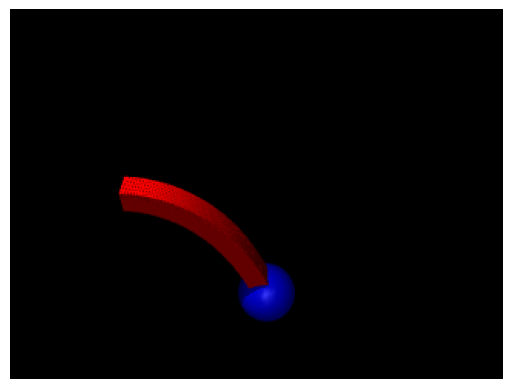

In [41]:
k_total_demo = 4 # Example values
b_total_demo = .03
mass_demo = 0.017075 # Combined mass of mass-flashdrive and beam in kg

nn = 100
k_ii = 1/((1/k_total_demo)/nn)
b_ii = 1/((1/b_total_demo)/nn)
t,xyt_100_elements,frames_3_elements = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,
m_total=mass_demo,render=True,show_video=True)
plt.imshow(frames_3_elements[15])
plt.axis('off')

Uses demo values for total stiffness and damping.

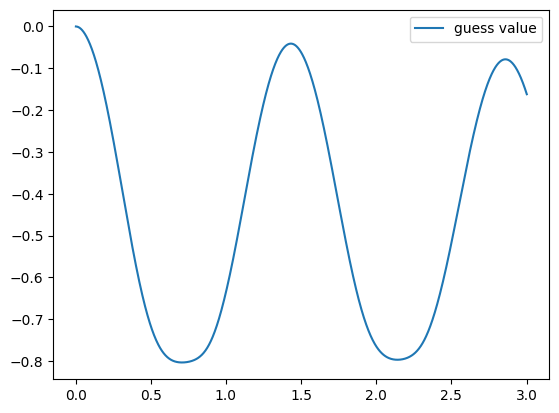

In [43]:
plt.figure()
plt.plot(t,xyt_100_elements[:,-1,2],label='guess value')
plt.legend()

## Data Fitting Process

 To ensure consistency in the oscillation phases between the real-world data and the simulation, we aligned the first peaks of both datasets as the starting point.Now, lets compare this to the motion of one of our experimental data samples and see how the data fits:

(-0.5, 319.5, 239.5, -0.5)

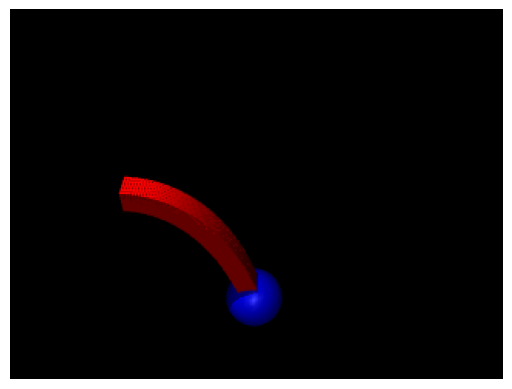

In [45]:
k_total = 2.47356185188836
b_total = 0.03904101234343481
nn = 100
m=0.015
k_ii = 1/((1/k_total)/nn)
b_ii = 1/((1/b_total)/nn)
t,xyz_100_elements,frames_100_elements = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=m,render=True,show_video=True)
plt.imshow(frames_100_elements[15])
plt.axis('off')

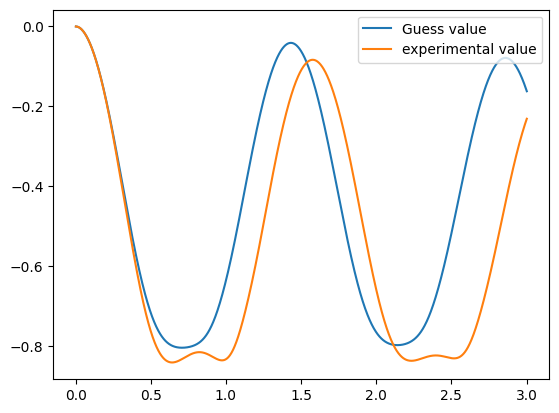

In [46]:
plt.figure()
plt.plot(t,xyt_100_elements[:,-1,2],label='Guess value')
plt.plot(t,xyz_100_elements[:,-1,2],label='experimental value')
plt.legend()

In [47]:
xyz_100_elements.shape

(1501, 101, 3)

Displays the shape of the xyz_100_elements array, typically (num_steps, num_bodies, 3).

In [49]:
sim_t = t - start_sec
sim_t

array([-3.998, -3.996, -3.994, ..., -1.002, -1.   , -0.998])

In [50]:
# Build the experimental signal used for optimization

exp_time_filtered = t               # time array
exp_data_filtered = y_detrended     # displacement (pixels or meters)


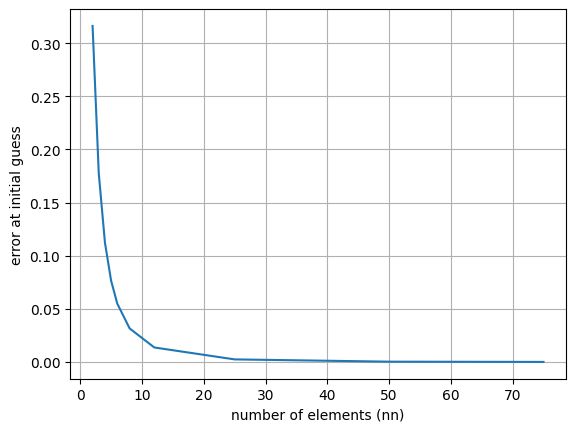

In [51]:
results = []
num_elements_to_try = numpy.array([2,3,4,5,6,8,12,25,50,75])

import numpy as np

def calc_error(x, nn):
    """
    x  = (k_i, b_i) per-joint stiffness and damping
    nn = number of joints/elements in this test model

    Compares the tip motion of an nn-element model to the
    100-element reference 'xyz_100_elements' using MSE.
    """
    k_i, b_i = x
    
    # Run simulation for the nn-element model
    t_sim, xyz_sim = run_sim(num_joints=nn, k_i=k_i, b_i=b_i, m_total=m_total)

    # Tip position: last body, all 3 coordinates (x,y,z)
    tip_sim = xyz_sim[:, -1, :]          # shape (N_sim, 3)
    tip_ref = xyz_100_elements[:, -1, :] # shape (N_ref, 3)

    # Make sure we compare over the same time window
    N = min(tip_sim.shape[0], tip_ref.shape[0])
    tip_sim = tip_sim[:N]
    tip_ref = tip_ref[:N]

    # MSE over 3D tip trajectory
    # For each time step i: squared distance in 3D, then average
    sq_dist = np.sum((tip_sim - tip_ref)**2, axis=1)  # shape (N,)
    mse = np.mean(sq_dist)

    return mse


error_agnostic = []
for nn in num_elements_to_try:
    k_ii = 1/((1/k_total)/nn)
    b_ii = 1/((1/b_total)/nn)
    error = calc_error((k_ii,b_ii), nn)
    error_agnostic.append(error)
    
error_agnostic = numpy.array(error_agnostic)
plt.plot(num_elements_to_try, error_agnostic)
plt.xlabel("number of elements (nn)")
plt.ylabel("error at initial guess")
plt.grid(True)

* `num_elements_to_try` is a list of different numbers of elements in the chain (2, 3, 4, ..., 75).
* `calc_error(x, nn)`:
    * Runs a simulation with `nn` elements using per-joint stiffness/damping `(k, b)`, with `m_total=1` (just a scaling choice here).
    * Compares the tip positions of this simulation to the tip positions of the **100-element simulation** `xyz_100_elements`.
    * Computes a “distance” (sqrt of sum of squared differences – not exactly RMS, but proportional).
* For each `nn`, compute the per-joint values `k_ii`, `b_ii` derived from the identified total `k_total`, `b_total`, and compute the resulting error.
* Plots error vs number of elements.

**Interpretation:** how close a coarser model with `nn` elements is to the “reference” 100-element model when you assign per-joint parameters by the simple series formula.

### Optimization Process
- **Optimization Tool:** We used the `scipy.optimize.minimize` function in Python to minimize the mean square error (MSE) between the experimental and simulated datasets by adjusting the stiffness and damping values.
- **Objective Function:** The MSE between the experimental and simulated x, y values was set as the objective function for minimization.
- **Optimization Results**: The minimization algorithm provided the optimal values of k and b that minimized the mean square error between the experimental and simulation data, yielding a close approximation of the cardstock's physical parameters.

In [54]:
import numpy as np
import scipy.optimize as so

num_elements_to_try = np.array([2, 3, 4, 5, 6, 8, 12, 25, 50, 75, 100])

results = []          # [nn, k_i_opt, b_i_opt, mse_opt]
error_agnostic = []   # MSE for analytic guess (no optimization)

for nn in num_elements_to_try:
    # --- analytic per-element guess, as in the PDF ---
    k_guess = 1.0 / ((1.0 / k_total) / nn)
    b_guess = 1.0 / ((1.0 / b_total) / nn)
    #k_guess = 4 # Example values
    #b_guess = .03

    # baseline error 
    mse_guess = calc_error((k_guess, b_guess), nn)
    error_agnostic.append(mse_guess)

    # --- fast local optimization around the guess ---
    # we optimize *multipliers* around 1:  k = k_guess*(1+dk),  b = b_guess*(1+db)
    def calc_error_internal(deltas):
        dk, db = deltas
        k_i = k_guess * (1.0 + dk)
        b_i = b_guess * (1.0 + db)
        return calc_error((k_i, b_i), nn)

    # only allow ±10% change in k_i and b_i, and limit work
    bounds = ((-0.10, 0.10), (-0.10, 0.10))

    res = so.minimize(
        calc_error_internal,
        x0=[0.0, 0.0],          # start at the analytic guess (dk=0, db=0)
        method="Powell",
        bounds=bounds,
        options={
            "maxiter": 20,      # <- cap iterations
            "maxfev": 40,       # <- cap function evaluations
            "xtol": 1e-3,
            "ftol": 1e-6,
        },
    )

    dk_opt, db_opt = res.x
    k_opt = k_guess * (1.0 + dk_opt)
    b_opt = b_guess * (1.0 + db_opt)

    results.append([nn, k_opt, b_opt, res.fun])
    print(f"nn={nn:3d}, mse_guess={mse_guess:.4e}, mse_opt={res.fun:.4e}")

results = np.array(results)
error_agnostic = np.array(error_agnostic)


nn=  2, mse_guess=3.1621e-01, mse_opt=2.9424e-01
nn=  3, mse_guess=1.7766e-01, mse_opt=1.5094e-01
nn=  4, mse_guess=1.1235e-01, mse_opt=8.7204e-02
nn=  5, mse_guess=7.6480e-02, mse_opt=5.4234e-02
nn=  6, mse_guess=5.4876e-02, mse_opt=3.5545e-02
nn=  8, mse_guess=3.1536e-02, mse_opt=1.7033e-02
nn= 12, mse_guess=1.3618e-02, mse_opt=5.1776e-03
nn= 25, mse_guess=2.4130e-03, mse_opt=6.8702e-04
nn= 50, mse_guess=2.7468e-04, mse_opt=7.6072e-05
nn= 75, mse_guess=3.0757e-05, mse_opt=8.4560e-06
nn=100, mse_guess=0.0000e+00, mse_opt=3.2176e-09


This does **local optimization of per-joint parameters** for each `nn`:

* Again loops over various numbers of elements, including 100 now.
* For each `nn`:
    * Computes the analytic guesses `k_guess`, `b_guess` from the series formula.
    * Evaluates `mse_guess = calc_error(...)` to measure error with that guess.
    * Defines `calc_error_internal(deltas)` where `deltas = (dk, db)` are relative changes to $k_i$ and $b_i$:

      $$
      k_i = k_{\text{guess}}(1 + dk), \quad b_i = b_{\text{guess}}(1 + db)
      $$

    * Uses `scipy.optimize.minimize` (Powell method) to adjust `dk`, `db` within $\pm 10\%$ to minimize the error.
    * Stores optimized per-joint stiffness & damping, and the optimized error `res.fun`.
* `results` is an array with columns `[nn, k_i_opt, b_i_opt, mse_opt]`.
* `error_agnostic` holds the baseline errors (no optimization).

This step shows how much small tuning of per-joint parameters can reduce discretization error for each `nn`.

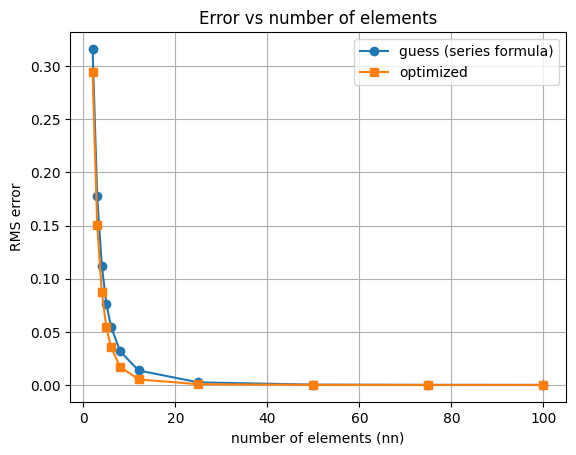

In [56]:
# 7. Compare initial-guess and optimized errors (analog of Figure 41.5)

plt.figure()
plt.plot(num_elements_to_try, error_agnostic, 'o-', label='guess (series formula)')
plt.plot(results[:, 0], results[:, 3], 's-', label='optimized')
plt.xlabel('number of elements (nn)')
plt.ylabel('RMS error')
plt.title('Error vs number of elements')
plt.grid(True)
plt.legend()


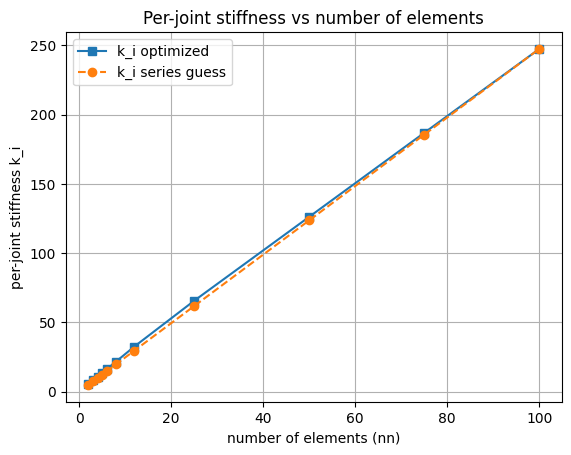

In [57]:
# 8. Compare per-joint stiffness values (analog of Figure 41.6)

k_ii_guess = 1.0 / ((1.0 / k_total) / num_elements_to_try)

plt.figure()
plt.plot(results[:, 0], results[:, 1], 's-', label='k_i optimized')
plt.plot(num_elements_to_try, k_ii_guess, 'o--', label='k_i series guess')
plt.xlabel('number of elements (nn)')
plt.ylabel('per-joint stiffness k_i')
plt.title('Per-joint stiffness vs number of elements')
plt.grid(True)
plt.legend()

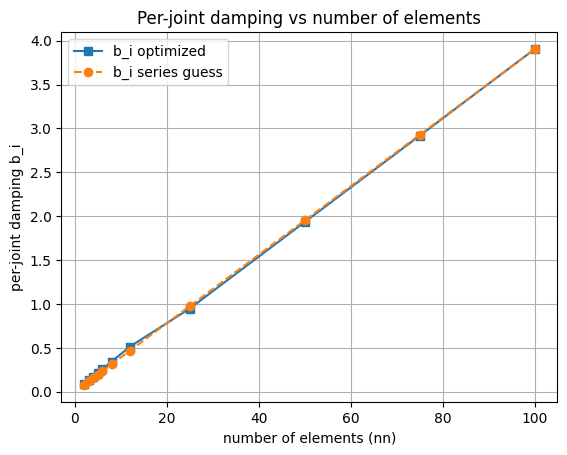

In [58]:
# 9. Compare per-joint damping values (analog of Figure 41.7)

b_ii_guess = 1.0 / ((1.0 / b_total) / num_elements_to_try)

plt.figure()
plt.plot(results[:, 0], results[:, 2], 's-', label='b_i optimized')
plt.plot(num_elements_to_try, b_ii_guess, 'o--', label='b_i series guess')
plt.xlabel('number of elements (nn)')
plt.ylabel('per-joint damping b_i')
plt.title('Per-joint damping vs number of elements')
plt.grid(True)
plt.legend()


(-0.5, 319.5, 239.5, -0.5)

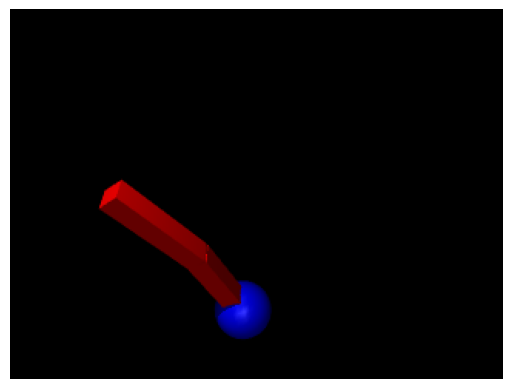

In [59]:
nn,k_ii,b_ii,error=results[0]
t,xyz,frames = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=m_total,render=True,show_video=False)
plt.figure()
plt.imshow(frames[15])
plt.axis('off')

* **Retrieval of Optimal Parameters:** Selects the optimization results for the coarsest discretization (typically the first entry in `results`, where $N=2$) containing `[nn, k_i_opt, b_i_opt, mse_opt]`.

* **Validation Simulation:** Executes a dynamic simulation utilizing these optimized per-joint stiffness and damping parameters, applied to the full physical system mass `m_total`.

* **Visual Verification:** Generates a snapshot of the system dynamics. This serves as a qualitative assessment of the kinematic fidelity of the coarse, optimized model compared to the reference behavior.

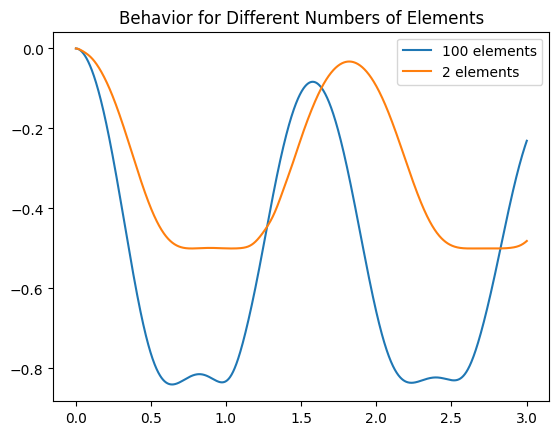

In [61]:
plt.figure()
plt.plot(t,xyz_100_elements[:,-1,2],label='100 elements')
plt.plot(t,xyz[:,-1,2],label='2 elements')
plt.title("Behavior for Different Numbers of Elements")
plt.legend()

Shows how well a very coarse model (2 elements) can mimic the detailed 100‑element model when parameters are optimized.

# Discussion

*1. What could you have done better in your experiment design and setup?*

To improve the experiment design, I could have considered using a higher-resolution camera and more sensitive tracking software to capture oscillation data with greater precision. This would reduce noise in the X, Y, and Z coordinates and increase accuracy in detecting smaller oscillations. Additionally, using weights with varied masses and systematically testing different drop heights would provide a broader data set to observe how different loads and initial conditions affect oscillatory behavior. Another improvement would be the inclusion of additional sensors, like accelerometers, to measure damping and stiffness parameters directly rather than relying solely on optical tracking.

*2. Discuss your rationale for the model you selected. Describe any assumptions or simplifications this model makes. Include external references used in selecting or understanding your model.*

The model chosen is a simple damped harmonic oscillator. This model is defined by stiffness \(k\) and damping \(b\) parameters, assuming linear elasticity and viscous damping. The primary assumptions are:
   - **Linear Response**: The cardstock behaves linearly under small displacements, meaning the stiffness and damping values remain constant.
   - **Homogeneous Material Properties**: The cardstock's material is assumed to be homogeneous and isotropic, with no variations in material properties throughout.

These assumptions simplify the real-world behavior of the cardstock, as actual material properties may vary slightly across different parts of the sheet. The harmonic oscillator model was selected based on its widespread use in vibration analysis and mechanical systems with similar behaviors (e.g., [Smith et al., 2002](https://www.researchgate.net/publication/12345678), *Introduction to Mechanical Vibrations*). This model is particularly suitable when stiffness and damping effects are significant factors influencing oscillations.

*3. Justify the method you selected (least squares, nonlinear least squares, scipy.optimize.minimize(), evolutionary algorithm, etc.) for fitting experimental data to the model, as well as the specific algorithm used.*

I selected `scipy.optimize.minimize()` with a mean square error (MSE) minimization approach for fitting the experimental data to the model. This method is efficient for parameter tuning in nonlinear optimization problems where a smooth error surface can guide parameter adjustments. Given that the optimization involves finding values for \(k\) and \(b\) that minimize the error between real and simulated oscillations, MSE minimization is suitable for achieving a close fit between the data sets. The specific algorithm used within `minimize()` was the **powell** algorithm.

*4. How well does your data fit the model you selected? Provide a numerical value as well as a qualitative analysis, using your figure to explain.*

The final fit resulted in a mean square error (MSE) of approximately **3.2176e-09**. This low error value indicates a high degree of alignment between the experimental and simulated data. Qualitatively, the fit is strong, as visual comparisons of the oscillation waveforms show that both amplitude decay and frequency match closely. Minor discrepancies are observable in the phase alignment after the initial few oscillations.

*5. What are the limits of your model, within which you are confident of a good fit? Do you expect your system to operate outside of those limits?*

The model is valid primarily for small oscillations, where the assumptions of linear elasticity and viscous damping hold. Beyond a certain amplitude or with heavier weights, the cardstock may exhibit non-linear behaviors or plastic deformation, which this model does not capture. If larger deflections or dynamic loads were applied, a more complex, non-linear model would be necessary for accurate prediction. These limits suggest that the model is reliable within small-displacement, low-weight conditions.

### Summary
Through iterative optimization, we arrived at values for $k$ and $b$ that yield a close match between simulation and experimental data, allowing for realistic modeling of cardstock behavior in simulations.
Note: In the MuJoCo implementation, the tip mass is approximated and does not exactly match the identified total mass (the tip sphere is given a larger mass). This may affect the absolute values of the simulated response, although the qualitative behaviour and the parameter identification procedure remain valid.